In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from fredapi import Fred
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from sklearn.metrics import mean_squared_error

fred = Fred(api_key="388e4633f23c88b89679b89794f572ed")
from tqdm import tqdm

import warnings

warnings.filterwarnings("ignore")

In [41]:
# loans = fred.get_series("CCLACBW027SBOG").rename("loans")
loans = pd.read_csv('consumerloans_clean.csv', index_col=0, parse_dates=True).rename(columns={"consumerloans": "loans"})
claims = fred.get_series("ICSA").rename('claims')  # Weekly
eff_funds = fred.get_series("FF").rename('eff_funds')  # Weekly
deposits = fred.get_series("DPSACBW027SBOG").rename('deposits')  # Weekly

arimax_df = pd.DataFrame(loans)
for s in [eff_funds, deposits]:
    arimax_df = pd.merge_asof(arimax_df, s, left_index=True, right_index=True)
arimax_df[['eff_funds_l1', 'deposits_l1']] = arimax_df[['eff_funds', 'deposits']].shift(1).bfill()
arimax_df['deposits_l1_log_ret'] = np.log(arimax_df['deposits_l1']).diff().bfill()

In [42]:
arimax_df

,loans,eff_funds,deposits,eff_funds_l1,deposits_l1,deposits_l1_log_ret
date,,,,,,
2000-06-28,551.643510,6.53,3576.1524,6.53,3576.1524,0.000000
2000-07-05,554.377885,6.85,3625.4808,6.53,3576.1524,0.000000
2000-07-12,553.241385,6.44,3613.4882,6.85,3625.4808,0.013699
2000-07-19,554.903785,6.50,3619.9306,6.44,3613.4882,-0.003313
2000-07-26,554.138385,6.50,3639.3521,6.50,3619.9306,0.001781
...,...,...,...,...,...,...
2024-03-13,1053.400000,5.33,17535.5968,5.33,17494.1022,0.002918
2024-03-20,1054.565700,5.33,17568.9661,5.33,17535.5968,0.002369
2024-03-27,1053.803300,5.33,17645.4336,5.33,17568.9661,0.001901


In [43]:
p=q=range(7)
arimax_models = np.empty((len(p), len(q)), dtype=object)
arimax_results = np.empty((len(p), len(q)), dtype=object)
for ar_lags in tqdm(p):
    for ma_lags in q:
        arimax = ARIMA(
            arimax_df.loans,
            order=(ar_lags, 1, ma_lags),
            exog=arimax_df[['eff_funds_l1', 'deposits_l1_log_ret']],
        )
        arimax_models[ar_lags, ma_lags] = arimax
        arimax_results[ar_lags, ma_lags] = arimax.fit()
arimax_aics = np.array(list(map(lambda r: r.aic, arimax_results.flatten()))).reshape(
    len(p), len(q)
)
arimax_aics = pd.DataFrame(arimax_aics, index=p, columns=q)

100%|██████████| 7/7 [00:40<00:00,  5.79s/it]


In [44]:
arima_models = np.empty((len(p), len(q)), dtype=object)
arima_results = np.empty((len(p), len(q)), dtype=object)
for ar_lags in tqdm(p):
    for ma_lags in q:
        arima = ARIMA(
            arimax_df.loans,
            order=(ar_lags, 1, ma_lags),
        )
        arima_models[ar_lags, ma_lags] = arima
        arima_results[ar_lags, ma_lags] = arima.fit()
arima_aics = np.array(list(map(lambda r: r.aic, arima_results.flatten()))).reshape(
    len(p), len(q)
)
arima_aics = pd.DataFrame(arima_aics, index=p, columns=q)

100%|██████████| 7/7 [00:24<00:00,  3.47s/it]


In [45]:
arima_aics

,0,1,2,3,4,5,6
0,5893.474225,5857.960885,5854.390152,5853.715282,5772.339611,5760.109527,5761.850614
1,5852.367088,5768.527580,5768.448444,5767.951067,5761.692919,5729.581966,5727.998905
2,5847.725236,5768.700824,5769.659671,5769.924526,5763.631942,5729.860836,5603.945975
3,5831.802553,5766.594730,5766.124471,5578.836163,5582.115731,5770.898000,5694.121095
4,5744.447336,5738.904189,5604.635949,5571.216628,5581.522432,5569.891904,5562.195863
5,5735.151882,5735.806085,5577.880363,5562.298214,5562.429753,5585.186590,5592.639930
6,5733.936916,5735.145290,5576.259607,5575.497376,5553.285628,5590.201710,5589.177329


In [46]:
arimax_aics

,0,1,2,3,4,5,6
0,5880.769291,5843.588526,5840.658209,5841.210082,5762.263539,5746.363016,5747.916278
1,5838.230391,5758.072386,5756.959720,5755.992364,5749.394391,5719.340271,5715.484411
2,5835.165993,5757.382514,5757.967702,5757.920660,5751.374065,5718.711930,5595.363310
3,5820.714509,5754.242295,5753.390053,5561.337844,5561.917652,5543.359290,5535.332700
4,5731.653879,5724.820502,5584.812263,5554.721744,5563.571453,5551.320230,5544.446616
5,5719.649216,5719.377427,5562.113769,5550.708439,5545.410345,5567.784275,5571.959928
6,5716.515608,5717.726001,5560.878110,5561.922684,5535.922385,5574.313009,5560.620315


In [47]:
arima_aics.stack().idxmin()

(6, 4)

In [48]:
arimax_aics.stack().idxmin()

(3, 6)

In [54]:
arimax_results[3,6].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  loans   No. Observations:                 1242
Model:                 ARIMA(3, 1, 6)   Log Likelihood               -2755.666
Date:                Thu, 25 Apr 2024   AIC                           5535.333
Time:                        14:55:32   BIC                           5596.817
Sample:                    06-28-2000   HQIC                          5558.455
                         - 04-10-2024                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
eff_funds_l1            1.4939      0.465      3.211      0.001       0.582       2.406
deposits_l1_log_ret   -37.0718      5.210     -7.116      0.000     -47.283     -26.861
ar.L1                   1.2142      0.015     79.343      0.000       1.184       1.244
ar.L2                  -1.2374      0.005   -248.209      0.000      -1.247      -1.228
ar.L3                   0.9636      0.015     63.656      0.000       0.934       0.993
ma.L1                  -1.1323      0.023    -49.955      0.000      -1.177      -1.088
ma.L2                   1.3254      0.034     38.990      0.000       1.259       1.392
ma.L3                  -0.9461      0.045    -21.176      0.000      -1.034      -0.859
ma.L4                   0.0812      0.046      1.773      0.076      -0.009       0.171
ma.L5                  -0.0330      0.033     -1.006      0.314      -0.097       0.031
ma.L6                  -0.0820      0.024     -3.458      0.001      -0.129      -0.036
sigma2                  4.9710      0.130     38.286      0.000       4.717       5.225
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              1330.35
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.56
Prob(H) (two-sided):                  0.66   Kurtosis:                         7.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
exog_forecast = np.zeros((52,2))

In [50]:
ieffr = pd.read_csv('ieffr.csv')
ieffr.set_index('Date', inplace=True)

In [51]:
exog_forecast[:, 0] = ieffr['Implied EFFR'].values
exog_forecast

array([[5.33   , 0.     ],
       [5.33   , 0.     ],
       [5.32   , 0.     ],
       [5.32   , 0.     ],
       [5.32   , 0.     ],
       [5.32   , 0.     ],
       [5.32   , 0.     ],
       [5.32   , 0.     ],
       [5.2865 , 0.     ],
       [5.2865 , 0.     ],
       [5.2865 , 0.     ],
       [5.2865 , 0.     ],
       [5.2865 , 0.     ],
       [5.2865 , 0.     ],
       [5.2865 , 0.     ],
       [5.2035 , 0.     ],
       [5.2035 , 0.     ],
       [5.2035 , 0.     ],
       [5.2035 , 0.     ],
       [5.2035 , 0.     ],
       [5.2035 , 0.     ],
       [5.2035 , 0.     ],
       [5.08625, 0.     ],
       [5.08625, 0.     ],
       [5.08625, 0.     ],
       [5.08625, 0.     ],
       [5.08625, 0.     ],
       [5.08625, 0.     ],
       [5.08625, 0.     ],
       [5.08625, 0.     ],
       [5.03942, 0.     ],
       [5.03942, 0.     ],
       [5.03942, 0.     ],
       [5.03942, 0.     ],
       [5.03942, 0.     ],
       [4.91008, 0.     ],
       [4.91008, 0.     ],
 

Main forecast for next 2 years. ARIMAX (3,1,6). Only uses IFFER as exogenous variable. Maybe the plot should be made more pretty.

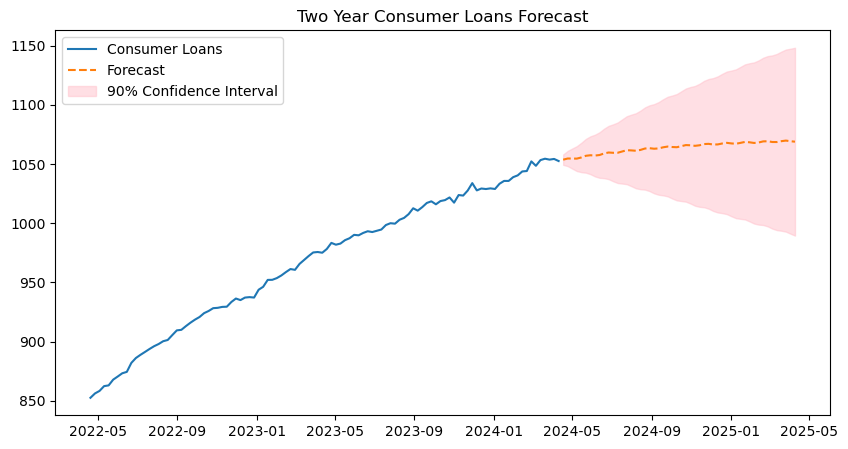

<Axes: >

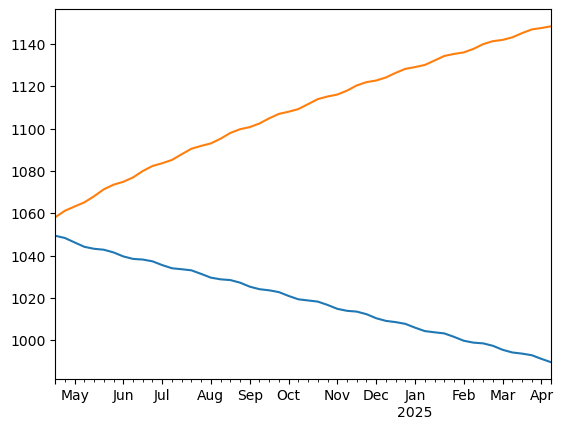

In [52]:
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(loans[-104:], label='Consumer Loans')
fc = arimax_results[3,6].get_forecast(steps=52, exog=exog_forecast).summary_frame()
plt.plot(fc['mean'], linestyle='dashed', label='Forecast')
plt.fill_between(fc.index, fc.mean_ci_upper, fc.mean_ci_lower, color='pink', alpha=0.5, label='90% Confidence Interval')
plt.legend(loc='upper left')

# Show the plot
plt.title('Two Year Consumer Loans Forecast')
plt.show()

fc['mean_ci_lower'].plot()
fc['mean_ci_upper'].plot()

Making one step ahead 